In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
file_path = "/mnt/12TB/jet_omer/cms_jet_data.h5"
key = "data"
data = pd.read_hdf(file_path, key=key)

In [3]:
df = pd.DataFrame(data)
df_filtered = df[(df["jetGenMatch"] != 0) & (df["genJetPt"] > 20) & (abs(df["jetEta"]) < 2.5)]
df_filtered = df_filtered.head(1000000)
df_filtered

,jetPt,genJetPt,jetRawPt,jetEta,jetPhi,jetMass,jetGenMatch,QG_ptD,QG_mult,QG_axis2,jetArea
0,201.199554,201.982956,191.304138,-0.455842,-1.927541,20.587746,1,0.489665,16,0.009762,0.488692
1,154.892838,156.991348,148.450638,0.014880,1.769757,18.438292,1,0.311253,26,0.027024,0.488692
2,105.403564,104.787613,91.705650,-2.155736,0.339309,17.063622,1,0.520251,11,0.028507,0.478719
3,1263.015747,1230.496338,1196.449341,0.024581,-1.778938,65.909691,1,0.464368,21,0.005259,0.498666
4,742.551147,783.408325,695.258301,-0.602228,1.542989,67.713173,1,0.484394,48,0.008470,0.488692
...,...,...,...,...,...,...,...,...,...,...,...
1016891,80.023300,73.909576,76.860245,-0.579579,1.461758,7.789685,1,0.411929,12,0.024094,0.508639
1016892,1197.598267,1195.401123,1129.613403,-0.529351,1.904920,51.110294,1,0.539395,18,0.002632,0.498666
1016893,1127.606689,1139.826904,1067.924438,0.060281,-1.871312,122.438332,1,0.572421,48,0.010540,0.498666
1016894,708.982361,696.721741,655.216370,0.947884,0.566378,71.126854,1,0.396109,34,0.017771,0.518612


In [4]:
exclude_columns = ["genJetPt", "jetPt", "jetGenMatch"]

features = df_filtered[[col for col in df.columns if col not in exclude_columns]]
target = df_filtered["genJetPt"]


scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [5]:

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features_scaled, target, test_size=0.4, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [6]:
X_jet_train, X_jet_temp, y_jet_train, y_jet_temp = train_test_split(df_filtered["jetPt"], target, test_size=0.4, random_state=42)
X_jet_validation, X_jet_test, y_jet_validation, y_jet_test = train_test_split(X_jet_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameters grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Initialize Random Forest Regressor
# rf_regressor = RandomForestRegressor(random_state=42)

# # Initialize Grid Search Cross Validation
# grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, 
#                            cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)

# # Perform Grid Search
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters
# print("Best Hyperparameters:", grid_search.best_params_)

# # Get the best model
# best_rf_regressor = grid_search.best_estimator_

# # Predict on the test set using the best model
# y_pred = best_rf_regressor.predict(X_test)

# # Evaluate the best model using Mean Absolute Error
# mae = mean_absolute_error(y_test, y_pred)
# print("Mean Absolute Error:", mae)


In [8]:
# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=10, min_samples_leaf=4, min_samples_split=10)

# Train the model
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model using Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 14.92241552285739


In [11]:

def bin_ratio(basejet_hist, genjet_hist):
    

    log_bins = np.logspace(np.log10(genjet_hist.min()), np.log10(genjet_hist.max()), 50)
    _, bin_edges = np.histogram(genjet_hist, bins=log_bins)

    ratios = []
    mean_list = []
    std_list = []
    iqr_list = []  # List to store interquartile ranges
    median_list = []  # List to store medians

    for ibin in range(len(bin_edges) - 1):
        idx = (basejet_hist >= bin_edges[ibin]) & (basejet_hist <= bin_edges[ibin + 1])  # boolean mask
        ratios.append((basejet_hist[idx] - 0 * genjet_hist[idx]) / genjet_hist[idx])

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    for hist in ratios:
        if len(hist) > 0:  # Check if hist is not empty
            mean_list.append(np.mean(hist))
            std_list.append(np.std(hist))
            iqr = np.percentile(hist, 75) - np.percentile(hist, 25)  # Interquartile range calculation
            iqr_list.append(iqr)
            median_list.append(np.median(hist))
        else:
            mean_list.append(np.nan)  # Append NaN if hist is empty
            std_list.append(np.nan)
            iqr_list.append(np.nan)
            median_list.append(np.nan)

    iqr_ratio = np.array(iqr_list) / np.array(median_list)  # Calculating IQR ratio

    return np.array(mean_list), np.array(std_list), bin_centers, bin_edges, iqr_ratio



basetogen_mean, basetogen_std, bin_centers, bin_edges, basetogen_iqr_ratio = bin_ratio(X_jet_test, y_test)
corrtogen_mean, corrtogen_std, _, _, corrtogen_iqr_ratio = bin_ratio(y_pred.flatten(), y_test)

# Check for division by zero and NaN values
valid_indices = (basetogen_iqr_ratio != 0) & (~np.isnan(corrtogen_iqr_ratio)) & (~np.isnan(basetogen_iqr_ratio))

# Calculate the ratio difference only for valid indices
beta = np.zeros_like(basetogen_iqr_ratio)
beta[valid_indices] = 1 - (corrtogen_iqr_ratio[valid_indices] / basetogen_iqr_ratio[valid_indices])


np.save('/home/odokumaci/git_repo/correction-repo/randomf_corriqr.npy', corrtogen_iqr_ratio)
np.save('/home/odokumaci/git_repo/correction-repo/randomf_corrtogen.npy', corrtogen_mean)
np.save('/home/odokumaci/git_repo/correction-repo/randomf_baseiqr.npy', y_pred)



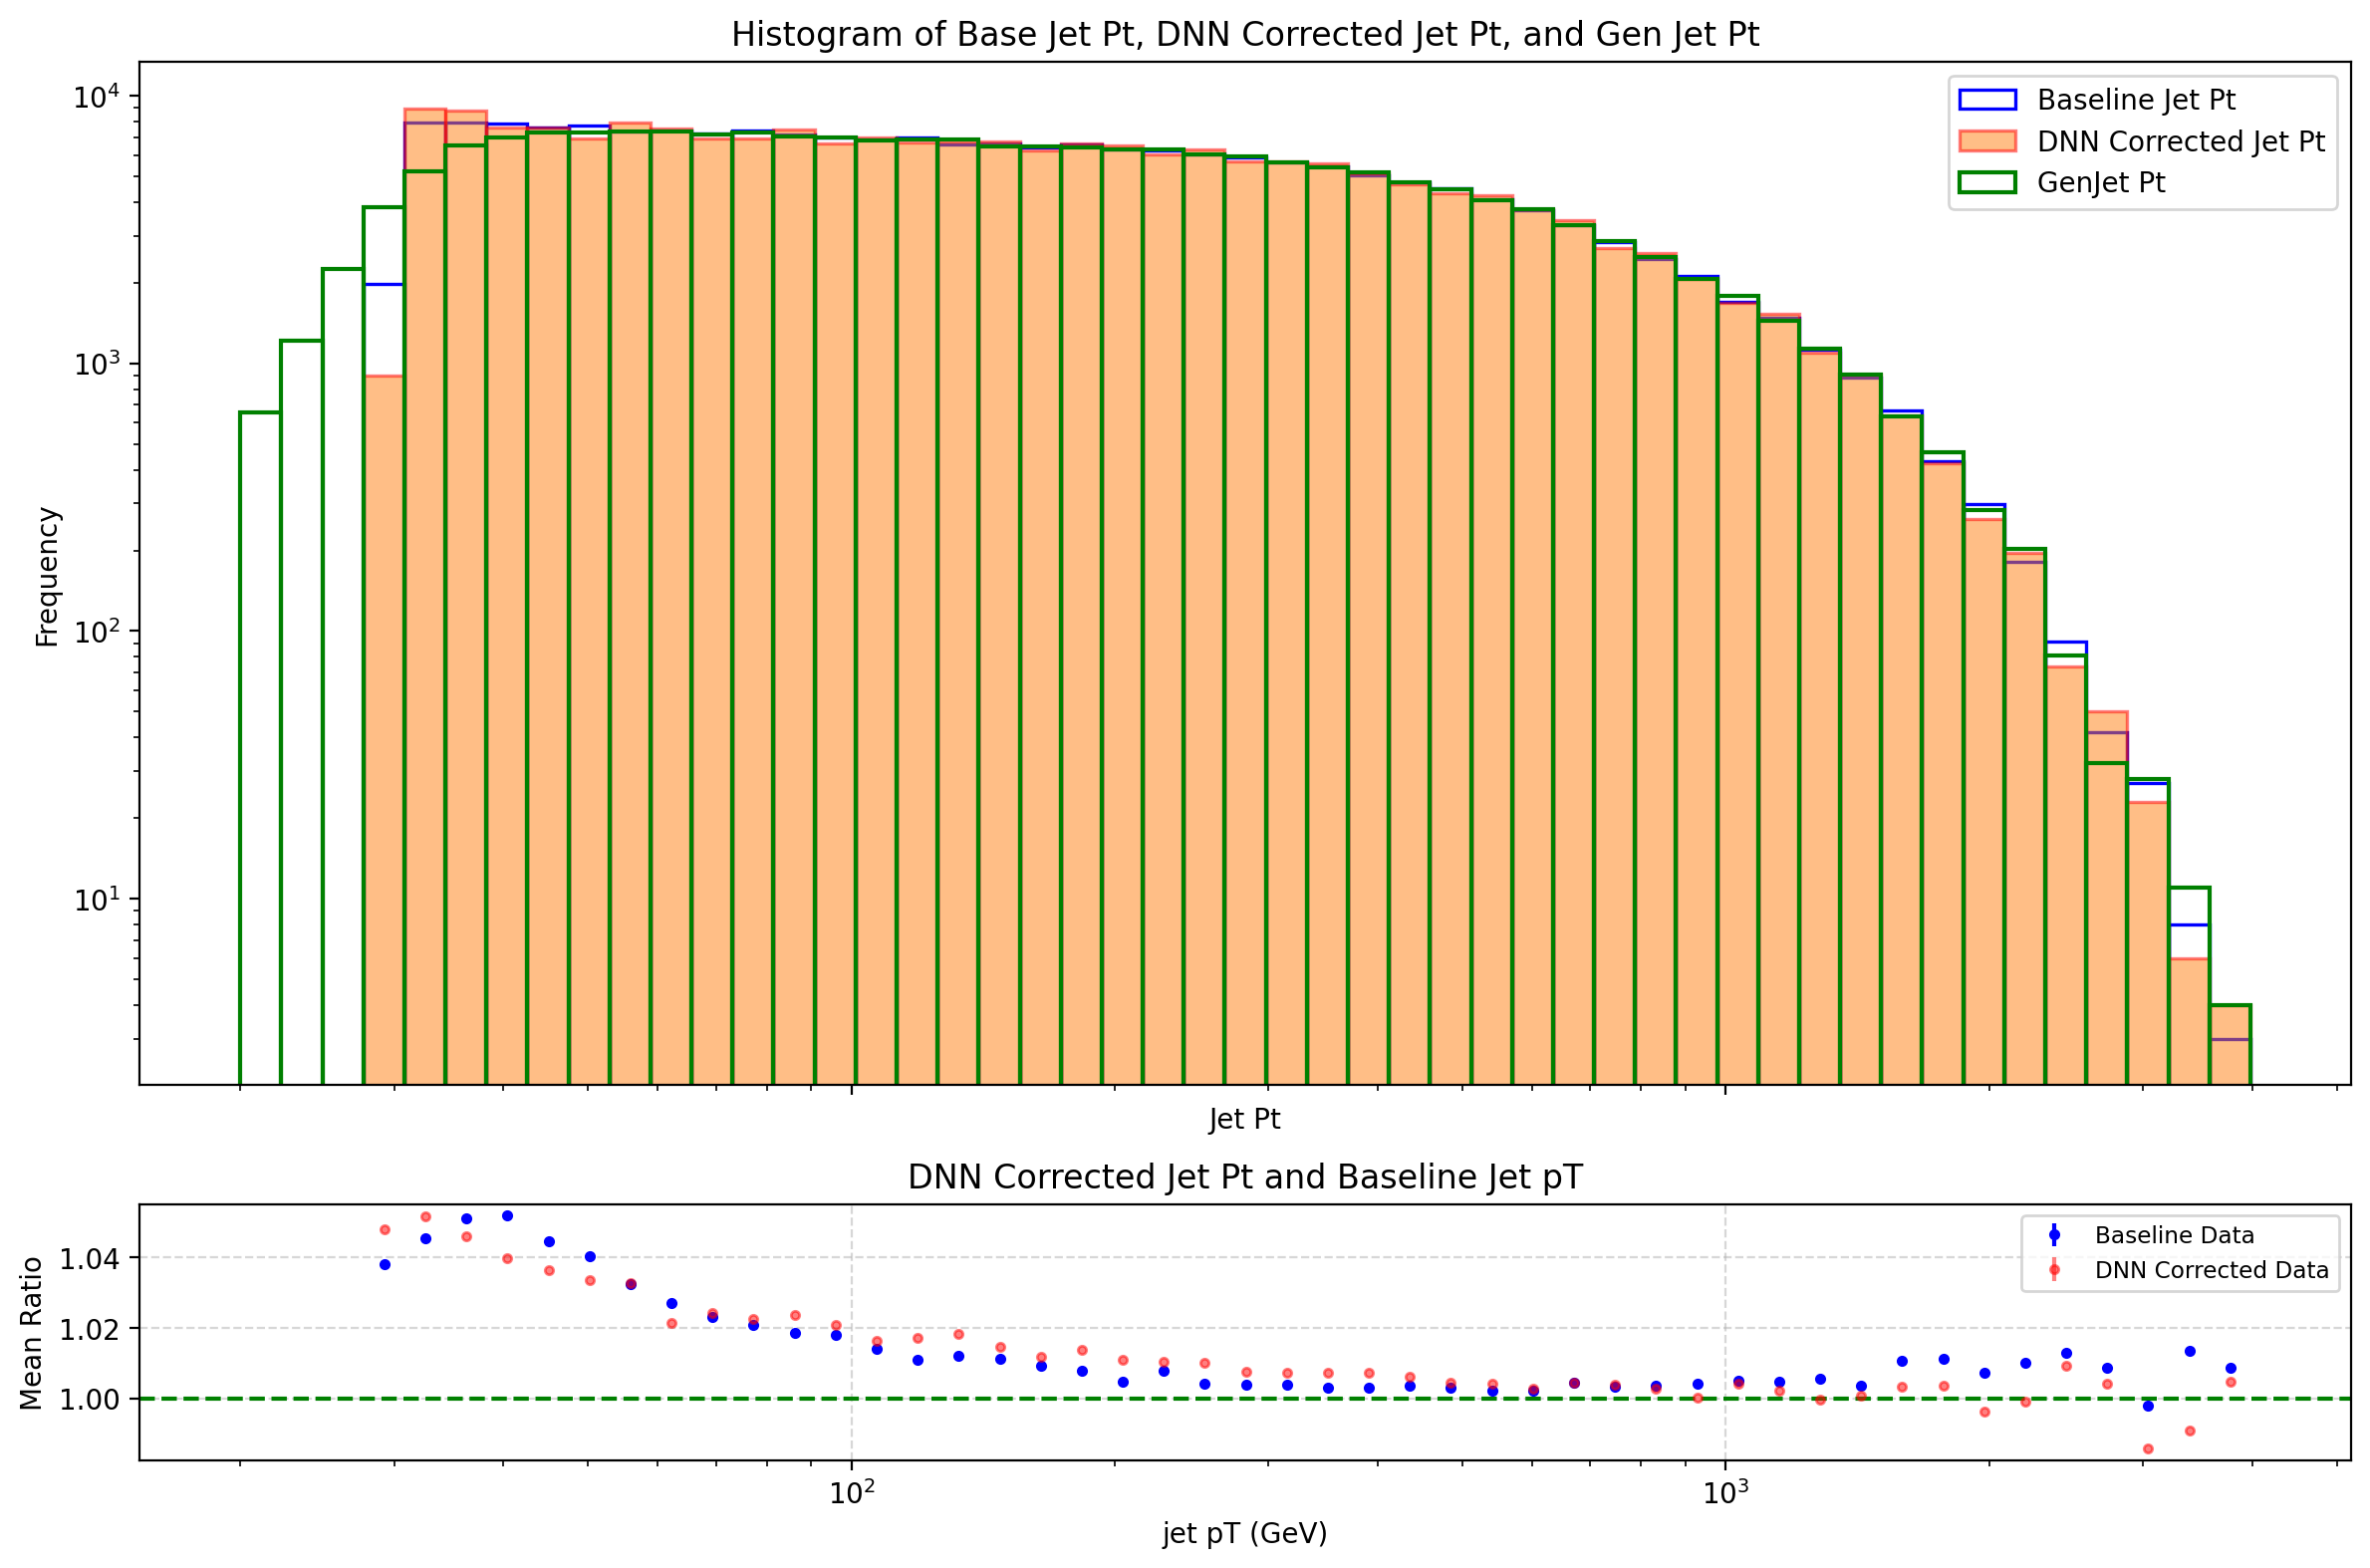

In [12]:
# Plotting the histogram and ratio plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', gridspec_kw={'height_ratios': [4, 1]}, figsize=(12, 8))


#common_bin_edges = np.linspace(min(X_test_original_scale[:, 0].min(), y_pred.min(), y_test.min()), max(X_test_original_scale[:, 0].max(), y_pred.max(), y_test.max()), 100)

ax1.hist(X_jet_test, bins=bin_edges, label='Baseline Jet Pt', fill=0, edgecolor='blue', linewidth=1.2)
ax1.hist(y_pred, bins=bin_edges, label='DNN Corrected Jet Pt', edgecolor="red", alpha=0.5, linewidth=1.2)
ax1.hist(y_test, bins=bin_edges, label='GenJet Pt', fill=0, edgecolor='green', linewidth=1.5)

ax1.set_xlabel('Jet Pt')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Base Jet Pt, DNN Corrected Jet Pt, and Gen Jet Pt')
ax1.set_yscale('log')
ax1.legend()


ax2.errorbar(bin_centers, basetogen_mean, yerr=0 * basetogen_std, fmt='o', markersize=3.0, color='blue', label='Baseline Data')
ax2.errorbar(bin_centers, corrtogen_mean, yerr=0 * corrtogen_std, fmt='o', markersize=3.0, alpha=0.5, color='red', label='DNN Corrected Data')
ax2.axhline(y=1.0, color='g', linestyle='--')

ax2.set_xlabel('jet pT (GeV)')
ax2.set_ylabel('Mean Ratio')
ax2.set_title('DNN Corrected Jet Pt and Baseline Jet pT')
ax2.set_xscale('log')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend(fontsize='small')

#ax1.set_xlim(0, 2500)
#ax2.set_xlim(0, 2500)

plt.tight_layout()
plt.show()